# NeuralProphet para Forecast de CMg

NeuralProphet combina lo mejor de Prophet con redes neuronales:
- **Auto-regresión (AR)**: Usa valores pasados para predecir
- **Estacionalidad**: Patrones diarios, semanales, anuales
- **Redes neuronales**: Captura relaciones no lineales
- **PyTorch backend**: Rápido y con soporte GPU

In [1]:
# Instalar si es necesario
#!pip install neuralprophet

In [2]:
# Imports
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime

# NeuralProphet
from neuralprophet import NeuralProphet, set_log_level, load, save

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Agregar el directorio raíz al path
sys.path.insert(0, os.path.abspath('..'))

# Configuración
warnings.filterwarnings('ignore')
set_log_level('ERROR')  # Reducir verbosidad
pd.set_option('display.max_columns', None)

print("Librerías cargadas correctamente")

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


Librerías cargadas correctamente


In [3]:
# Cargar y preparar datos
df_raw = pd.read_parquet(os.path.join('..', 'data', 'Test_i', 'traindataset.parquet'))

In [4]:
df_raw.tail()

,Fecha,Hora,CMg,datetime,hour,temperature_2m_lag0,temperature_2m_lag1,temperature_2m_lag2,temperature_2m_lag3,temperature_2m_lag4,temperature_2m_lag5,temperature_2m_lag6,temperature_2m_lag7,relative_humidity_2m_lag0,relative_humidity_2m_lag1,relative_humidity_2m_lag2,relative_humidity_2m_lag3,relative_humidity_2m_lag4,relative_humidity_2m_lag5,relative_humidity_2m_lag6,relative_humidity_2m_lag7,dew_point_2m_lag0,dew_point_2m_lag1,dew_point_2m_lag2,dew_point_2m_lag3,dew_point_2m_lag4,dew_point_2m_lag5,dew_point_2m_lag6,dew_point_2m_lag7,apparent_temperature_lag0,apparent_temperature_lag1,apparent_temperature_lag2,apparent_temperature_lag3,apparent_temperature_lag4,apparent_temperature_lag5,apparent_temperature_lag6,apparent_temperature_lag7,precipitation_lag0,precipitation_lag1,precipitation_lag2,precipitation_lag3,precipitation_lag4,precipitation_lag5,precipitation_lag6,precipitation_lag7,rain_lag0,rain_lag1,rain_lag2,rain_lag3,rain_lag4,rain_lag5,rain_lag6,rain_lag7,snowfall_lag0,snowfall_lag1,snowfall_lag2,snowfall_lag3,snowfall_lag4,snowfall_lag5,snowfall_lag6,snowfall_lag7,cloud_cover_lag0,cloud_cover_lag1,cloud_cover_lag2,cloud_cover_lag3,cloud_cover_lag4,cloud_cover_lag5,cloud_cover_lag6,cloud_cover_lag7,wind_speed_10m_lag0,wind_speed_10m_lag1,wind_speed_10m_lag2,wind_speed_10m_lag3,wind_speed_10m_lag4,wind_speed_10m_lag5,wind_speed_10m_lag6,wind_speed_10m_lag7,wind_direction_10m_lag0,wind_direction_10m_lag1,wind_direction_10m_lag2,wind_direction_10m_lag3,wind_direction_10m_lag4,wind_direction_10m_lag5,wind_direction_10m_lag6,wind_direction_10m_lag7,surface_pressure_lag0,surface_pressure_lag1,surface_pressure_lag2,surface_pressure_lag3,surface_pressure_lag4,surface_pressure_lag5,surface_pressure_lag6,surface_pressure_lag7,evapotranspiration_lag0,evapotranspiration_lag1,evapotranspiration_lag2,evapotranspiration_lag3,evapotranspiration_lag4,evapotranspiration_lag5,evapotranspiration_lag6,evapotranspiration_lag7,shortwave_radiation_lag0,shortwave_radiation_lag1,shortwave_radiation_lag2,shortwave_radiation_lag3,shortwave_radiation_lag4,shortwave_radiation_lag5,shortwave_radiation_lag6,shortwave_radiation_lag7,date,holiday_name,is_holiday,day_of_week,month,year
57768,2025-08-03,20,65.061728,2025-08-03 20:00:00,20.0,2.7,3.4,5.1,7.7,8.3,8.6,8.9,8.2,90.0,90.0,87.0,72.0,68.0,69.0,69.0,77.0,1.2,1.9,3.1,2.9,2.7,3.3,3.5,4.4,0.3,1.1,2.8,4.9,5.3,5.7,5.8,5.5,0.0,0.0,0.0,0.0,0.1,0.2,0.1,0.1,0.0,0.0,0.0,0.0,0.1,0.2,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,4.0,11.0,24.0,22.0,37.0,59.0,40.0,2.9,3.6,5.0,8.1,9.3,9.3,10.4,9.4,292.0,311.0,341.0,356.0,341.0,344.0,350.0,5.0,1005.7,1005.3,1004.8,1004.6,1003.9,1003.5,1003.3,1003.2,None,None,None,None,None,None,None,None,0.0,0.0,43.0,164.0,243.0,284.0,433.0,437.0,2025-08-03,None,0,6.0,8.0,2025.0
57769,2025-08-03,21,64.566495,2025-08-03 21:00:00,21.0,2.3,2.7,3.4,5.1,7.7,8.3,8.6,8.9,95.0,90.0,90.0,87.0,72.0,68.0,69.0,69.0,1.6,1.2,1.9,3.1,2.9,2.7,3.3,3.5,0.0,0.3,1.1,2.8,4.9,5.3,5.7,5.8,0.0,0.0,0.0,0.0,0.0,0.1,0.2,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.2,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,13.0,4.0,11.0,24.0,22.0,37.0,59.0,3.1,2.9,3.6,5.0,8.1,9.3,9.3,10.4,291.0,292.0,311.0,341.0,356.0,341.0,344.0,350.0,1005.9,1005.7,1005.3,1004.8,1004.6,1003.9,1003.5,1003.3,None,None,None,None,None,None,None,None,0.0,0.0,0.0,43.0,164.0,243.0,284.0,433.0,2025-08-03,None,0,6.0,8.0,2025.0
57770,2025-08-03,22,56.489353,2025-08-03 22:00:00,22.0,2.9,2.3,2.7,3.4,5.1,7.7,8.3,8.6,92.0,95.0,90.0,90.0,87.0,72.0,68.0,69.0,1.7,1.6,1.2,1.9,3.1,2.9,2.7,3.3,0.4,0.0,0.3,1.1,2.8,4.9,5.3,5.7,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,20.0,13.0,4.0,11.0,24.0,22.0,37.0,4.6,3.1,2.9,3.6,5.0,8.1,9.3,9.3,288.0,291.0,292.0,311.0,341.0,356.0,341.0,344.0,1006.0,1005.9,1005.7,1005.3,1004.8,1004.6,1003.9,1003.5,None,None,None,None,None,None,None,None,0.0,0.0,0.0,0.0,43.0,164.0,243.0,284.0,2025-08-03,None,0,6.0,8.0,2025.0
57771,2025-08-03,23,57.468722,2025-08-03 23:00:00,23.0,1.7,2.9,2.3,2.7

In [5]:
df_raw["hour"].value_counts()

hour
0.0     2408
12.0    2407
21.0    2407
20.0    2407
19.0    2407
18.0    2407
17.0    2407
16.0    2407
15.0    2407
14.0    2407
2.0     2407
1.0     2407
11.0    2407
10.0    2407
9.0     2407
8.0     2407
7.0     2407
6.0     2407
5.0     2407
4.0     2407
3.0     2407
13.0    2407
22.0    2406
23.0    2406
Name: count, dtype: int64

In [6]:
# Seleccionar columnas relevantes
df_raw = df_raw[['datetime', 'CMg', 'is_holiday']].copy()

# Eliminar filas con datetime nulo (hora 25)
df_raw = df_raw.dropna(subset=['datetime']).reset_index(drop=True)

# Filtrar desde 2023
df_raw = df_raw[df_raw['datetime'] >= datetime(2023, 1, 1)].reset_index(drop=True)

print(f"Datos cargados: {len(df_raw)} observaciones")
print(f"Desde: {df_raw['datetime'].min()}")
print(f"Hasta: {df_raw['datetime'].max()}")
df_raw.head()

Datos cargados: 22704 observaciones
Desde: 2023-01-01 00:00:00
Hasta: 2025-08-04 00:00:00


,datetime,CMg,is_holiday
0,2023-01-01 00:00:00,225.17,1
1,2023-01-01 01:00:00,171.56,1
2,2023-01-01 02:00:00,171.56,1
3,2023-01-01 03:00:00,164.95,1
4,2023-01-01 04:00:00,145.12,1


## Neural Prophet

In [7]:
# =============================================================================
# PREPARAR DATOS EN FORMATO NEURALPROPHET
# =============================================================================
# NeuralProphet requiere columnas 'ds' y 'y'

df = df_raw[['datetime', 'CMg']].copy()
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])
# Se dropea la única entrada duplicada
df = df.drop_duplicates(subset=["ds"])

print("Datos en formato NeuralProphet:")
print(f"  Columnas: {df.columns.tolist()}")
print(f"  Registros: {len(df)}")
print(f"  Rango: {df['ds'].min()} a {df['ds'].max()}")
df.head()

Datos en formato NeuralProphet:
  Columnas: ['ds', 'y']
  Registros: 22703
  Rango: 2023-01-01 00:00:00 a 2025-08-04 00:00:00


,ds,y
0,2023-01-01 00:00:00,225.17
1,2023-01-01 01:00:00,171.56
2,2023-01-01 02:00:00,171.56
3,2023-01-01 03:00:00,164.95
4,2023-01-01 04:00:00,145.12


In [8]:
# =============================================================================
# SEPARACIÓN TRAIN / TEST
# =============================================================================

test_size = 24  # Últimas 24 horas para test

df_train = df[:-test_size].copy().reset_index(drop=True)
df_test = df[-test_size:].copy().reset_index(drop=True)

print("=" * 60)
print("SEPARACIÓN DE DATOS")
print("=" * 60)
print(f"Train: {len(df_train)} obs | {df_train['ds'].min()} a {df_train['ds'].max()}")
print(f"Test:  {len(df_test)} obs | {df_test['ds'].min()} a {df_test['ds'].max()}")

SEPARACIÓN DE DATOS
Train: 22679 obs | 2023-01-01 00:00:00 a 2025-08-03 00:00:00
Test:  24 obs | 2025-08-03 01:00:00 a 2025-08-04 00:00:00


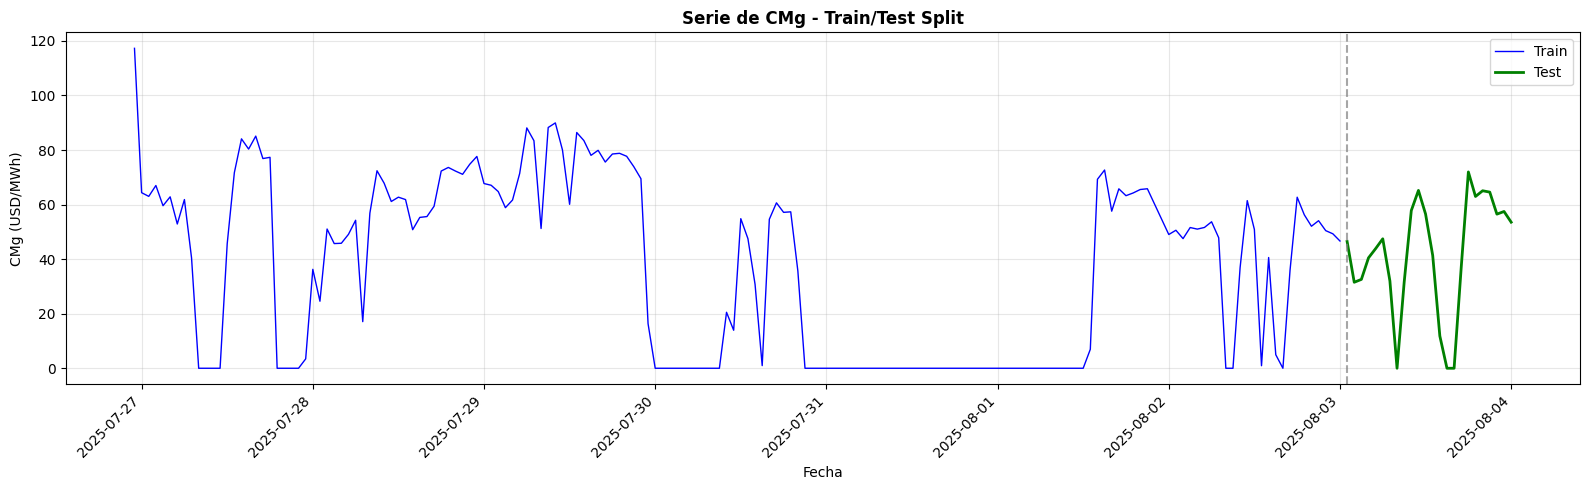

In [9]:
# Visualización de los datos
fig, ax = plt.subplots(figsize=(16, 5), dpi=100)

# Últimos 7 días de train + test
plot_days = 168
df_plot_train = df_train[-plot_days:]

ax.plot(df_plot_train['ds'], df_plot_train['y'], 'b-', linewidth=1, label='Train')
ax.plot(df_test['ds'], df_test['y'], 'g-', linewidth=2, label='Test')
ax.axvline(x=df_test['ds'].iloc[0], color='gray', linestyle='--', alpha=0.7)

ax.set_xlabel('Fecha')
ax.set_ylabel('CMg (USD/MWh)')
ax.set_title('Serie de CMg - Train/Test Split', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Modelo NeuralProphet

Configuración optimizada para datos horarios de energía:
- **n_lags=168**: Usa última semana (en horas captura patrón diario)
- **n_forecasts=24**: Predecir 24 horas adelante
- **Estacionalidad multiplicativa**: Mejor para datos con varianza cambiante

In [10]:
#model = load(os.path.join('../data/Test_i/modelo.np'))

In [11]:
# =============================================================================
# CREAR MODELO NEURALPROPHET
# =============================================================================
# Comentar todo el codigo siguiente si se carga un modelo ya entrenado

print("Configurando modelo NeuralProphet...")
print("=" * 60)

model = NeuralProphet(
    # -------------------------------------------------------------------------
    # Auto-regresión (CLAVE para series temporales)
    # -------------------------------------------------------------------------
    n_lags=168,              # Usar últimas 168 horas (1 semana) como input
    n_forecasts=1,          # Predecir 24 horas adelante
    
    # -------------------------------------------------------------------------
    # Estacionalidad
    # -------------------------------------------------------------------------
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='multiplicative',
    
    # -------------------------------------------------------------------------
    # Tendencia (no lineal con changepoints)
    # -------------------------------------------------------------------------
    growth='discontinuous',   # Permite cambios abruptos en tendencia
    n_changepoints=20,        # Más changepoints para capturar no linealidad
    changepoints_range=0.9,
    trend_reg=0.05,           # Menor regularización para más flexibilidad
    
    # -------------------------------------------------------------------------
    # Entrenamiento
    # -------------------------------------------------------------------------
    learning_rate=0.01,
    epochs=50,
    batch_size=64,
    
    # -------------------------------------------------------------------------
    # Regularización
    # -------------------------------------------------------------------------
    ar_reg=0.1,
    
    # -------------------------------------------------------------------------
    # Incertidumbre - IC 99%
    # -------------------------------------------------------------------------
    quantiles=[0.005, 0.995],  # IC 99%

    # -------------------------------------------------------------------------
    # Arquitectura de la red (LISTA de neuronas por capa)
    # -------------------------------------------------------------------------
    ar_layers=[32, 16],        # 2 capas: 32 neuronas -> 16 neuronas
    lagged_reg_layers=[16],    # 1 capa: 16 neuronas
)

print("Modelo configurado:")
print(f"  n_lags:        {model.n_lags}")
print(f"  n_forecasts:   {model.n_forecasts}")
print(f"  growth:        discontinuous (no lineal)")
print(f"  n_changepoints:{model.config_trend.n_changepoints}")
print(f"  quantiles:     [0.005, 0.995] (IC 99%)")
print(f"  epochs:        {model.config_train.epochs}")
print(f"  batch_size:    {model.config_train.batch_size}")

Configurando modelo NeuralProphet...
Modelo configurado:
  n_lags:        168
  n_forecasts:   1
  growth:        discontinuous (no lineal)
  n_changepoints:20
  quantiles:     [0.005, 0.995] (IC 99%)
  epochs:        50
  batch_size:    64


In [12]:
# =============================================================================
# ENTRENAR MODELO
# =============================================================================

print("Entrenando modelo NeuralProphet...")
print("=" * 60)

# Entrenar
metrics = model.fit(df_train, freq='H')

print("\nEntrenamiento completado")
print(f"Métricas finales:")
print(metrics.tail(5))

Entrenando modelo NeuralProphet...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]


Entrenamiento completado
Métricas finales:
    train_loss  reg_loss        MAE       RMSE      Loss   RegLoss  epoch
45    0.018986  0.003277  18.188618  30.955475  0.018984  0.003277     45
46    0.018904  0.003208  18.138979  31.121269  0.018902  0.003208     46
47    0.018845  0.003158  18.087173  31.094027  0.018843  0.003157     47
48    0.018798  0.003119  18.138283  30.932018  0.018792  0.003119     48
49    0.018764  0.003085  18.122475  31.046801  0.018764  0.003085     49


In [13]:
save(model, os.path.join('../data/Test_i/modelo.np'))  


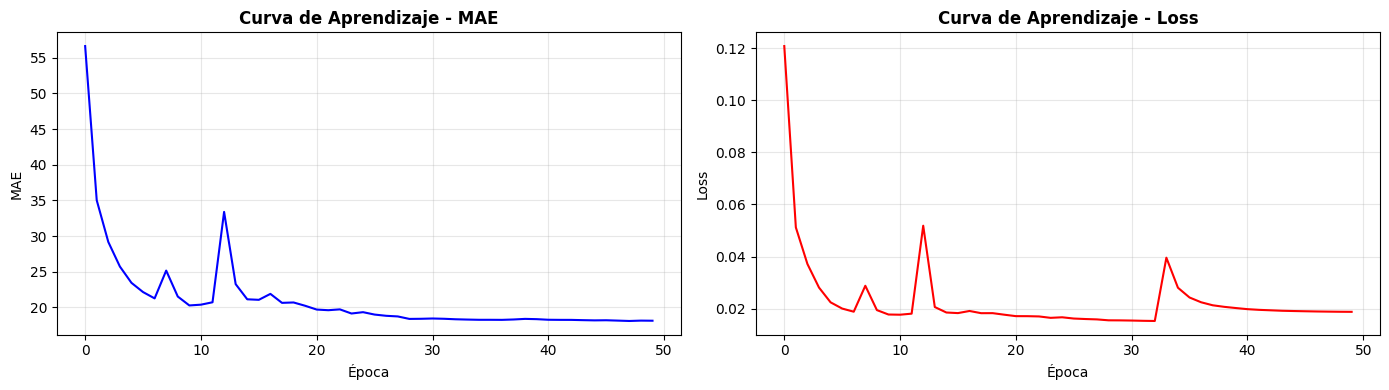

In [18]:
# Visualizar curva de aprendizaje
fig, axes = plt.subplots(1, 2, figsize=(14, 4), dpi=100)

# Loss
ax1 = axes[0]
ax1.plot(metrics['MAE'], 'b-', linewidth=1.5)
ax1.set_xlabel('Época')
ax1.set_ylabel('MAE')
ax1.set_title('Curva de Aprendizaje - MAE', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Loss con escala log
ax2 = axes[1]
if 'Loss' in metrics.columns:
    ax2.plot(metrics['Loss'], 'r-', linewidth=1.5)
    ax2.set_ylabel('Loss')
else:
    ax2.plot(metrics['MAE'], 'r-', linewidth=1.5)
    ax2.set_ylabel('MAE')
ax2.set_xlabel('Época')
ax2.set_title('Curva de Aprendizaje - Loss', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# =============================================================================
# ROLLING FORECAST: PREDECIR 1 HORA A LA VEZ
# =============================================================================
# Proceso:
# 1. Usar df_train para predecir hora 1
# 2. Agregar hora 1 REAL a los datos
# 3. Predecir hora 2
# 4. Agregar hora 2 REAL
# ... y así hasta completar 24 horas

print("=" * 60)
print("ROLLING FORECAST: 1 HORA A LA VEZ")
print("=" * 60)

# Lista para guardar resultados
resultados_rolling = []

# Copiar df_train para ir agregando datos reales
df_rolling = df_train[['ds', 'y']].copy()

# Iterar hora por hora
for i in range(len(df_test)):
    hora_actual = i + 1
    
    # Crear future para 1 paso adelante
    future = model.make_future_dataframe(df_rolling, periods=1)
    
    # Predecir
    forecast = model.predict(future)
    
    # Extraer la predicción (última fila, columna yhat1)
    prediccion = forecast['yhat1'].iloc[-1]
    
    # Extraer intervalos de confianza si existen
    if 'yhat1 0.5%' in forecast.columns:
        ic_lower = forecast['yhat1 0.5%'].iloc[-1]
        ic_upper = forecast['yhat1 99.5%'].iloc[-1]
    else:
        ic_lower = np.nan
        ic_upper = np.nan
    
    # Valor real de esta hora
    valor_real = df_test['y'].iloc[i]
    fecha_hora = df_test['ds'].iloc[i]
    
    # Guardar resultado
    resultados_rolling.append({
        'hora': hora_actual,
        'ds': fecha_hora,
        'y_real': valor_real,
        'y_pred': prediccion,
        'y_lower': ic_lower,
        'y_upper': ic_upper
    })
    
    # AGREGAR el valor REAL al dataset para la siguiente predicción
    nueva_fila = pd.DataFrame({'ds': [fecha_hora], 'y': [valor_real]})
    df_rolling = pd.concat([df_rolling, nueva_fila], ignore_index=True)
    
    # Mostrar progreso cada 6 horas
    if hora_actual % 6 == 0 or hora_actual == 1:
        print(f"  Hora {hora_actual:2d}/24 | Real: {valor_real:7.2f} | Pred: {prediccion:7.2f} | Error: {valor_real - prediccion:+7.2f}")

# Crear DataFrame de resultados
results = pd.DataFrame(resultados_rolling)
results['error'] = results['y_real'] - results['y_pred']
results['abs_error'] = np.abs(results['error'])

print("\n" + "=" * 60)
print("ROLLING FORECAST COMPLETADO")
print("=" * 60)
print(f"Predicciones realizadas: {len(results)}")
print(f"NaN en predicciones: {results['y_pred'].isna().sum()}")

ROLLING FORECAST: 1 HORA A LA VEZ


Predicting: |          | 0/? [00:00<?, ?it/s]

  Hora  1/24 | Real:   46.47 | Pred:   44.42 | Error:   +2.06


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  Hora  6/24 | Real:   47.46 | Pred:   46.45 | Error:   +1.00


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  Hora 12/24 | Real:   56.54 | Pred:   62.48 | Error:   -5.95


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  Hora 18/24 | Real:   71.96 | Pred:   50.26 | Error:  +21.70


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  Hora 24/24 | Real:   53.54 | Pred:   52.06 | Error:   +1.48

ROLLING FORECAST COMPLETADO
Predicciones realizadas: 24
NaN en predicciones: 0


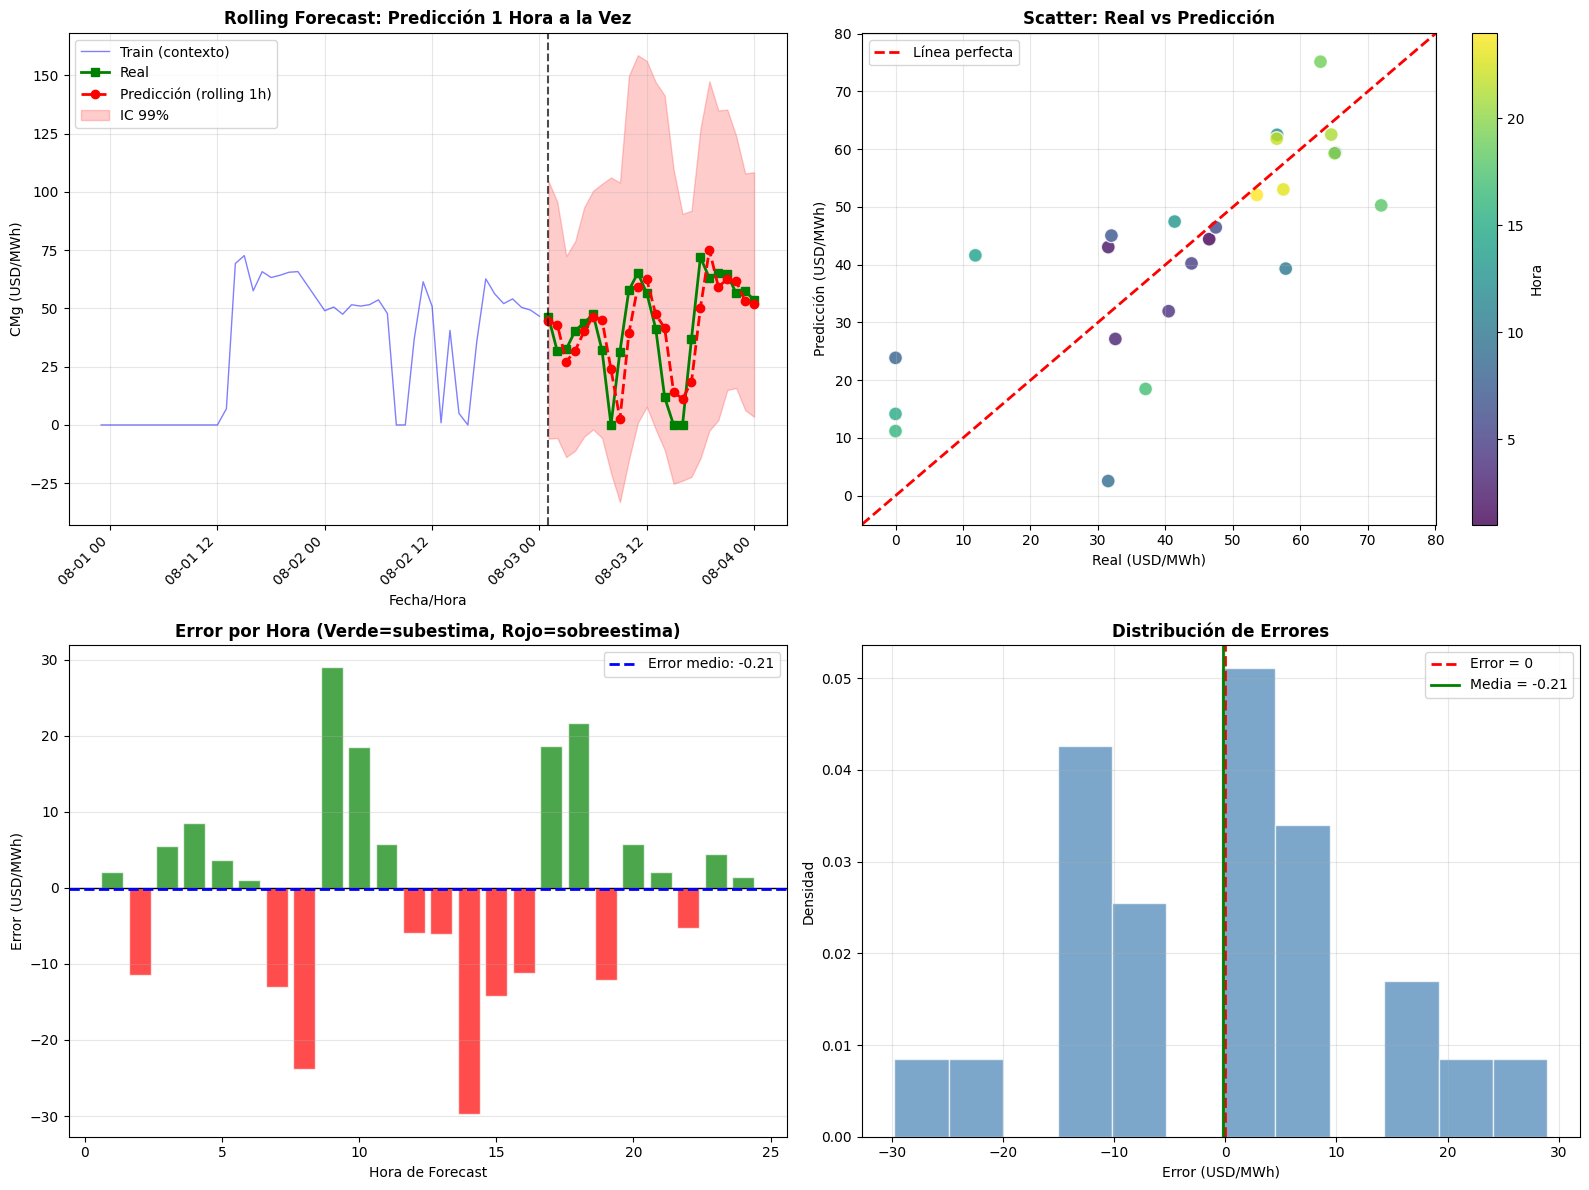

In [19]:
# =============================================================================
# VISUALIZACIÓN DEL ROLLING FORECAST
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=100)

# -----------------------------------------------------------------------------
# 1. Predicción vs Real (con contexto)
# -----------------------------------------------------------------------------
ax1 = axes[0, 0]

# Contexto: últimas 48 horas de train
context_hours = 48
df_context = df_train[-context_hours:]

ax1.plot(df_context['ds'], df_context['y'], 'b-', linewidth=1, alpha=0.5, label='Train (contexto)')
ax1.plot(results['ds'], results['y_real'], 'g-', linewidth=2, marker='s', markersize=6, label='Real')
ax1.plot(results['ds'], results['y_pred'], 'r--', linewidth=2, marker='o', markersize=6, label='Predicción (rolling 1h)')

# Intervalos de confianza si existen
if results['y_lower'].notna().any():
    ax1.fill_between(results['ds'], results['y_lower'], results['y_upper'], 
                     alpha=0.2, color='red', label='IC 99%')

ax1.axvline(x=results['ds'].iloc[0], color='black', linestyle='--', alpha=0.7)
ax1.set_xlabel('Fecha/Hora')
ax1.set_ylabel('CMg (USD/MWh)')
ax1.set_title('Rolling Forecast: Predicción 1 Hora a la Vez', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# -----------------------------------------------------------------------------
# 2. Scatter: Real vs Predicho
# -----------------------------------------------------------------------------
ax2 = axes[0, 1]

ax2.scatter(results['y_real'], results['y_pred'], c=results['hora'], cmap='viridis', 
            s=100, alpha=0.8, edgecolors='white')
plt.colorbar(ax2.collections[0], ax=ax2, label='Hora')

min_val = min(results['y_real'].min(), results['y_pred'].min()) - 5
max_val = max(results['y_real'].max(), results['y_pred'].max()) + 5
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Línea perfecta')

ax2.set_xlabel('Real (USD/MWh)')
ax2.set_ylabel('Predicción (USD/MWh)')
ax2.set_title('Scatter: Real vs Predicción', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(min_val, max_val)
ax2.set_ylim(min_val, max_val)

# -----------------------------------------------------------------------------
# 3. Error por Hora
# -----------------------------------------------------------------------------
ax3 = axes[1, 0]

colors = ['green' if e >= 0 else 'red' for e in results['error']]
ax3.bar(results['hora'], results['error'], color=colors, alpha=0.7, edgecolor='white')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.axhline(y=results['error'].mean(), color='blue', linestyle='--', linewidth=2, 
            label=f'Error medio: {results["error"].mean():.2f}')

ax3.set_xlabel('Hora de Forecast')
ax3.set_ylabel('Error (USD/MWh)')
ax3.set_title('Error por Hora (Verde=subestima, Rojo=sobreestima)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# -----------------------------------------------------------------------------
# 4. Distribución de Errores
# -----------------------------------------------------------------------------
ax4 = axes[1, 1]

ax4.hist(results['error'], bins=12, density=True, alpha=0.7, color='steelblue', edgecolor='white')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Error = 0')
ax4.axvline(x=results['error'].mean(), color='green', linestyle='-', linewidth=2, 
            label=f'Media = {results["error"].mean():.2f}')

ax4.set_xlabel('Error (USD/MWh)')
ax4.set_ylabel('Densidad')
ax4.set_title('Distribución de Errores', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# =============================================================================
# MÉTRICAS Y TABLA DETALLADA
# =============================================================================

# Calcular métricas
mae = results['abs_error'].mean()
rmse = np.sqrt((results['error'] ** 2).mean())
mape = (results['abs_error'] / results['y_real'].replace(0, np.nan)).mean() * 100

# R²
ss_res = ((results['y_real'] - results['y_pred']) ** 2).sum()
ss_tot = ((results['y_real'] - results['y_real'].mean()) ** 2).sum()
r2 = 1 - (ss_res / ss_tot)

# Cobertura del IC si existe
if results['y_lower'].notna().any():
    in_ic = ((results['y_real'] >= results['y_lower']) & (results['y_real'] <= results['y_upper'])).sum()
    coverage = in_ic / len(results) * 100
else:
    coverage = np.nan

print("=" * 70)
print("MÉTRICAS DE ERROR - ROLLING FORECAST (1 HORA A LA VEZ)")
print("=" * 70)

print("\n PREDICCIÓN PUNTUAL:")
print("-" * 50)
print(f"  MAE  (Error Absoluto Medio):     {mae:.2f} USD/MWh")
print(f"  RMSE (Raíz Error Cuadrático):    {rmse:.2f} USD/MWh")
print(f"  MAPE (Error Porcentual Medio):   {mape:.2f}%")
print(f"  R²   (Coef. Determinación):      {r2:.4f}")

if not np.isnan(coverage):
    print("\n INTERVALOS DE CONFIANZA (99%):")
    print("-" * 50)
    print(f"  Cobertura: {coverage:.1f}% (esperado: 99%)")

print("\n ESTADÍSTICOS DE ERROR:")
print("-" * 50)
print(f"  Error medio:     {results['error'].mean():+.2f} USD/MWh")
print(f"  Error std:       {results['error'].std():.2f} USD/MWh")
print(f"  Error min:       {results['error'].min():+.2f} USD/MWh")
print(f"  Error max:       {results['error'].max():+.2f} USD/MWh")

# Tabla detallada
print("\n" + "=" * 95)
print("TABLA DETALLADA HORA POR HORA")
print("=" * 95)
print(f"{'Hora':<5} {'Fecha/Hora':<20} {'Real':<10} {'Pred':<10} {'Error':<10} {'|Error|':<10} {'En IC?':<6}")
print("-" * 95)

for idx, row in results.iterrows():
    hora = int(row['hora'])
    fecha = row['ds'].strftime('%Y-%m-%d %H:%M')
    real = row['y_real']
    pred = row['y_pred']
    error = row['error']
    abs_err = row['abs_error']
    
    if not np.isnan(row['y_lower']):
        in_ic = "✓" if row['y_lower'] <= real <= row['y_upper'] else "✗"
    else:
        in_ic = "-"
    
    print(f"{hora:<5} {fecha:<20} {real:<10.2f} {pred:<10.2f} {error:<+10.2f} {abs_err:<10.2f} {in_ic:<6}")

print("-" * 95)
print(f"{'PROM':<5} {'':<20} {results['y_real'].mean():<10.2f} {results['y_pred'].mean():<10.2f} {results['error'].mean():<+10.2f} {mae:<10.2f}")

# Mostrar resultados
print("\n" + "=" * 70)
print("RESULTADOS FINALES")
print("=" * 70)
results

MÉTRICAS DE ERROR - ROLLING FORECAST (1 HORA A LA VEZ)

 PREDICCIÓN PUNTUAL:
--------------------------------------------------
  MAE  (Error Absoluto Medio):     10.88 USD/MWh
  RMSE (Raíz Error Cuadrático):    13.76 USD/MWh
  MAPE (Error Porcentual Medio):   31.97%
  R²   (Coef. Determinación):      0.5733

 INTERVALOS DE CONFIANZA (99%):
--------------------------------------------------
  Cobertura: 100.0% (esperado: 99%)

 ESTADÍSTICOS DE ERROR:
--------------------------------------------------
  Error medio:     -0.21 USD/MWh
  Error std:       14.06 USD/MWh
  Error min:       -29.78 USD/MWh
  Error max:       +28.97 USD/MWh

TABLA DETALLADA HORA POR HORA
Hora  Fecha/Hora           Real       Pred       Error      |Error|    En IC?
-----------------------------------------------------------------------------------------------
1     2025-08-03 01:00     46.47      44.42      +2.06      2.06       ✓     
2     2025-08-03 02:00     31.52      43.04      -11.52     11.52      ✓     

,hora,ds,y_real,y_pred,y_lower,y_upper,error,abs_error
0,1,2025-08-03 01:00:00,46.474163,44.418701,-5.914871,104.687698,2.055461,2.055461
1,2,2025-08-03 02:00:00,31.523140,43.043522,-5.616788,95.715416,-11.520382,11.520382
2,3,2025-08-03 03:00:00,32.572590,27.135504,-13.774127,72.463905,5.437086,5.437086
3,4,2025-08-03 04:00:00,40.471820,31.941504,-11.033714,78.847267,8.530316,8.530316
4,5,2025-08-03 05:00:00,43.859435,40.215645,-5.030693,93.360344,3.643790,3.643790
5,6,2025-08-03 06:00:00,47.455948,46.454475,-1.903926,100.488846,1.001472,1.001472
6,7,2025-08-03 07:00:00,31.990582,45.036167,-5.578017,103.473984,-13.045585,13.045585
7,8,2025-08-03 08:00:00,0.000000,23.859676,-20.673420,106.206657,-23.859676,23.859676
8,9,2025-08-03 09:00:00,31.511715,2.538527,-33.151558,104.013664,28.973188,28.973188
9,10,2025-08-03 10:00:00,57.817903,39.313034,-15.060264,149.811798,18.504868,18.504868
